# Customer Segmentation using RFM Analysis



## Load and Preview the Dataset


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Online Retail.xlsx to Online Retail.xlsx


In [ ]:
import pandas as pd

# Adjust to match the exact uploaded name
df = pd.read_excel('Online Retail.xlsx', engine='openpyxl')

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Cleaning
- Fixing data types (e.g., converting dates)
- Handling missing values
- Ensuring the dataset is suitable for RFM calculations


In [ ]:
# Add TotalPrice column (Quantity × UnitPrice)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Confirm it exists
df[['Quantity', 'UnitPrice', 'TotalPrice']].head()


,Quantity,UnitPrice,TotalPrice
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34


## Calculating RFM Metrics

 Calculate the RFM values for each customer:
- **Recency**: How recently they made a purchase
- **Frequency**: How often they purchase
- **Monetary**: How much they spend


In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


## Scoring RFM Segments

Score each RFM metric from 1 to 5 using quantiles.
The scores are combined to form an **RFM Score** like `545` or `111`, which helps us rank and classify customers.


In [ ]:
r_labels = [5, 4, 3, 2, 1]
f_labels = m_labels = [1, 2, 3, 4, 5]

rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=r_labels)
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=f_labels)
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=m_labels)

rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,12346.0,326,2,0.00,1,2,1,121
1,12347.0,2,7,4310.00,5,4,5,545
2,12348.0,75,4,1797.24,2,3,4,234
3,12349.0,19,1,1757.55,4,1,4,414
4,12350.0,310,1,334.40,1,1,2,112


## Segmenting Customers

Using RFM scores, we assign meaningful labels like:
- **Champions**
- **Loyal Customers**
- **At Risk**
- **Hibernating**
These help businesses tailor strategies to different customer types.


In [ ]:
def rfm_segment(row):
    r = int(row['R'])
    f = int(row['F'])
    m = int(row['M'])

    if r == 5 and f == 5:
        return 'Champions'
    elif r >= 4 and f >= 4:
        return 'Loyal Customers'
    elif r == 5 and f <= 3:
        return 'New Customers'
    elif r >= 3 and f <= 2:
        return 'Potential Loyalists'
    elif r <= 2 and f >= 4:
        return 'At Risk'
    elif r <= 2 and f <= 2:
        return 'Hibernating'
    else:
        return 'Need Attention'


In [ ]:
rfm['Segment'] = rfm.apply(rfm_segment, axis=1)


In [ ]:
# Save full RFM data
rfm.to_csv("rfm_segments.csv", index=False)

# Show download link
from IPython.display import FileLink
FileLink("rfm_segments.csv")


/content/rfm_segments.csv

## Merge RFM with Original Dataset

Combine the newly generated RFM metrics and segment labels back into the original dataset for further analysis.


In [ ]:
df_merged = df.merge(
    rfm[['CustomerID', 'R', 'F', 'M', 'RFM_Score', 'Segment']],
    on='CustomerID',
    how='left'
)

df_merged.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,R,F,M,RFM_Score,Segment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,1,5,5,155,At Risk
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1,5,5,155,At Risk
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,1,5,5,155,At Risk
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1,5,5,155,At Risk
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1,5,5,155,At Risk


In [ ]:
from IPython.display import display, Markdown

# Generate key business stats
summary_stats = {
    "Total Customers": df_merged['CustomerID'].nunique(),
    "Total Transactions": df_merged['InvoiceNo'].nunique(),
    "Total Revenue": f"${df_merged['TotalPrice'].sum():,.2f}",
    "Average Order Value": f"${df_merged['TotalPrice'].mean():.2f}",
    "Most Country": df_merged['Country'].mode()[0],
    "Most Segment": df_merged['Segment'].mode()[0],
}

# Display as Markdown table
display(Markdown("### Key Business"))
for k, v in summary_stats.items():
    print(f"{k}: {v}")


### Key Business

Total Customers: 4372
Total Transactions: 25900
Total Revenue: $9,747,747.93
Average Order Value: $17.99
Most Country: United Kingdom
Most Segment: Champions


## Visual Summary and Insights

This section includes:
- Bar and pie charts of customer segments
- Average spend per segment
- Geographic breakdown of key segments


/tmp/ipython-input-1075551033.py:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


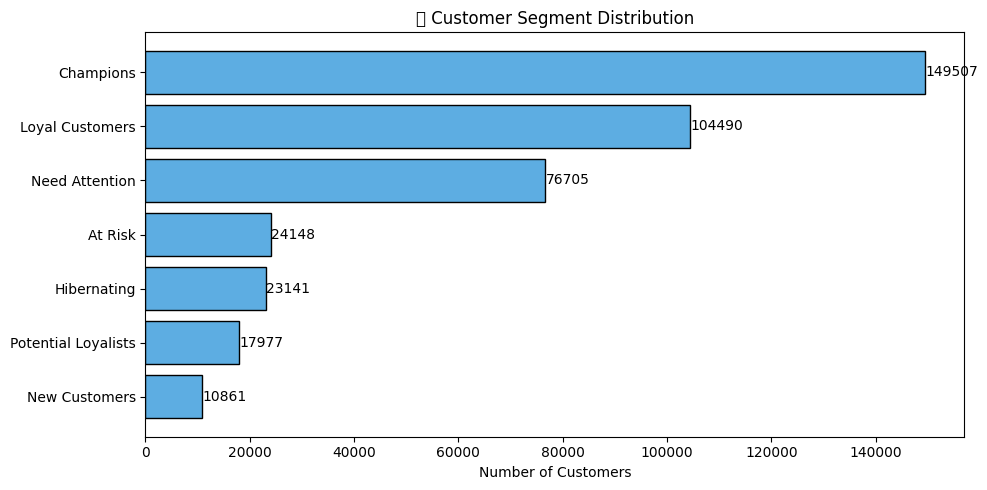

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
segment_counts = df_merged['Segment'].value_counts().sort_values()
bars = plt.barh(segment_counts.index, segment_counts.values, color="#5DADE2", edgecolor="black")

for bar in bars:
    width = bar.get_width()
    plt.text(width + 3, bar.get_y() + bar.get_height()/2,
             str(width), va='center')

plt.title('📊 Customer Segment Distribution')
plt.xlabel('Number of Customers')
plt.tight_layout()
plt.show()


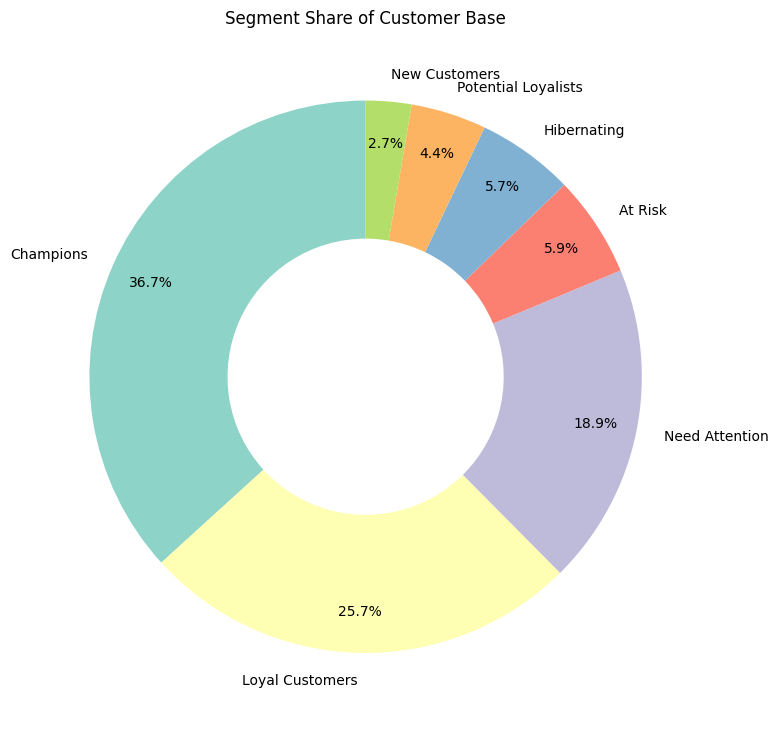

In [ ]:
plt.figure(figsize=(8,10))
df_merged['Segment'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Set3.colors,
    wedgeprops=dict(width=0.5),
    pctdistance=0.85
)
plt.title('Segment Share of Customer Base')
plt.ylabel('')
plt.tight_layout()
plt.show()


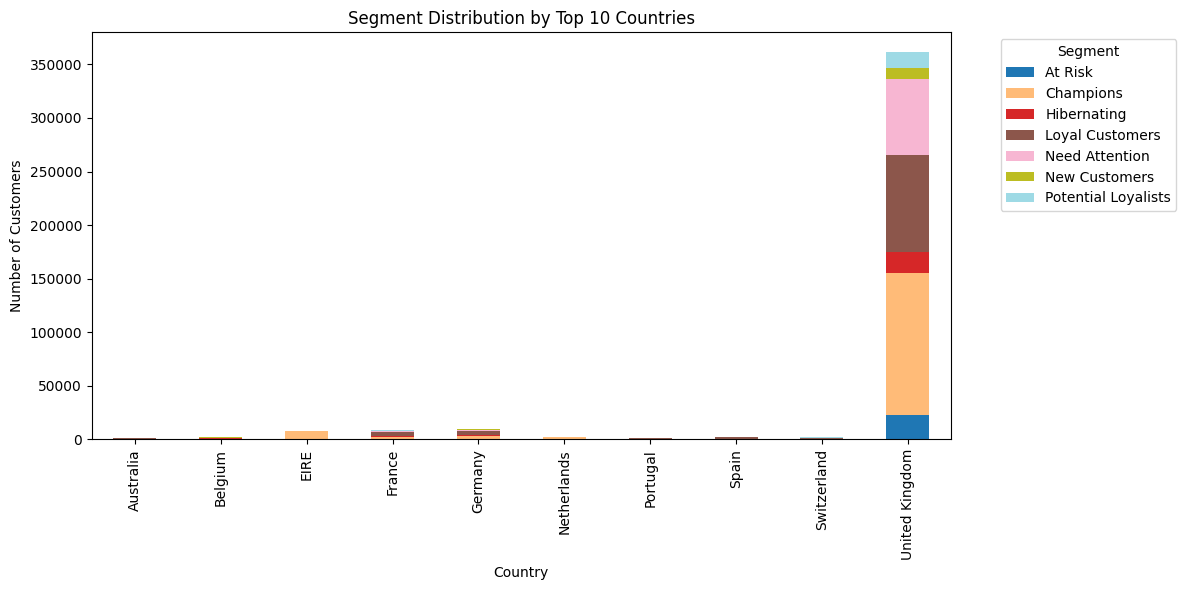

In [ ]:
top_countries = df_merged['Country'].value_counts().head(10).index
country_segment = df_merged[df_merged['Country'].isin(top_countries)].groupby(['Country', 'Segment']).size().unstack().fillna(0)

country_segment.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20')
plt.title("Segment Distribution by Top 10 Countries")
plt.ylabel("Number of Customers")
plt.xlabel("Country")
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Export Final Datasets



In [ ]:
# Save merged dataset
df_merged.to_csv("full_dataset_with_rfm.csv", index=False)
